In [5]:
from collections import defaultdict, namedtuple
import sys
import json
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [559]:
phase_dir = '../phased_ihart'
family_sizes = [3, 4, 5, 6]
identicals_file = '../sibpair_similarity/ihart_identicals.txt'
chrom = '20'
ped_file = '../data/v34.vcf.ped'


In [560]:
# pull cytobands
intervals = []
interval_count = 0
with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] == chrom:
            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2]), pieces[4]))
        interval_count += 1
intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))

interval_chroms = np.array([int(x[0]) for x in intervals])
first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()


In [561]:
# pull twins
identicals = set()
with open(identicals_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		identicals.update(pieces)
print('identicals', len(identicals))

identicals 176


In [562]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		if len(pieces) >= 6:
			fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
			child_id_to_affected[child_id] = disease_status
			child_id_to_sex[child_id] = sex
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 4611


In [563]:
# pull families and figure out how many non-identical kids they have
family_to_individuals = dict()
families_left_out = set()

for j in family_sizes:
	with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
		next(f) # skip header
		for line in f:
			pieces = line.strip().split('\t')
			family_key = pieces[0]
			individuals = pieces[1:(1+j)]

			if np.all([x not in identicals for x in individuals[2:]]):
				family_to_individuals[family_key] = individuals
			else:
				families_left_out.add(family_key)
print('families', len(family_to_individuals))
print('families removed due to identicals', len(families_left_out))

families 774
families removed due to identicals 85


In [590]:

individuals = sorted(sum(family_to_individuals.values(), []))
ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])
print('individuals', len(individuals))

# pull phase data for each family
family_to_states = defaultdict(list)
family_to_pos = defaultdict(list)
family_to_indices = defaultdict(list)
for j in family_sizes:
	with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
		next(f) # skip header

		for line in f:
			pieces = line.strip().split('\t')
			family_key = pieces[0]
			state = [int(x) for x in pieces[1:(2+(j*2))]]
			start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
			start_index, end_index = [int(x) for x in pieces[(4+(j*2)):(6+(j*2))]]
			assert end_pos >= start_pos

			family_to_states[family_key].append(state)
			family_to_pos[family_key].append((start_pos, end_pos))
			family_to_indices[family_key].append((start_index, end_index))
print('pulled phase data')


individuals 3472
pulled phase data


In [591]:
sibpairs = []
y = []
for family, inds in family_to_individuals.items():
    for index1, index2 in combinations(range(len(inds)-2), 2):
        child1, child2 = inds[2+index1], inds[2+index2]
        is_aff1, is_aff2 = child_id_to_affected[child1] == '2', child_id_to_affected[child2] == '2'
            
        if is_aff1 or is_aff2:
            if not is_aff1:
                sibpairs.append((child2, child1))
            else:
                sibpairs.append((child1, child2))
            y.append(is_aff1 and is_aff2)
y = np.array(y)
print(len(sibpairs), y.shape)
sibpair_to_index = dict([(x, i) for i, x in enumerate(sibpairs)])

X_mat = np.zeros((len(sibpairs), len(intervals)))
X_pat = np.zeros((len(sibpairs), len(intervals)))
for family, inds in family_to_individuals.items():
    states = family_to_states[family]
    positions = np.array(family_to_pos[family])
    
    for i, interval in enumerate(intervals):
        weights = np.clip(np.minimum(positions[:, 1], interval[3]) - np.maximum(positions[:, 0], interval[2]), 0, None)

        for index1, index2 in combinations(range(len(inds)-2), 2):
            child1, child2 = inds[2+index1], inds[2+index2]
            is_aff1, is_aff2 = child_id_to_affected[child1] == '2', child_id_to_affected[child2] == '2'
            if is_aff1 or is_aff2:
                if (child1, child2) in sibpair_to_index:
                    sibpair_index = sibpair_to_index[(child1, child2)]
                else:
                    sibpair_index = sibpair_to_index[(child2, child1)]

                share_mat = np.zeros((positions.shape[0],))
                share_pat = np.zeros((positions.shape[0],))
            
                share_mat[(state[4+2*index1]!=-1) & (state[4+2*index2]!=-1) & (state[4+2*index1]==state[4+2*index2])] = 1
                share_mat[(state[4+2*index1]!=-1) & (state[4+2*index2]!=-1) & (state[4+2*index1]!=state[4+2*index2])] = -1            
                share_pat[(state[5+2*index1]!=-1) & (state[5+2*index2]!=-1) & (state[5+2*index1]==state[5+2*index2])] = 1
                share_pat[(state[5+2*index1]!=-1) & (state[5+2*index2]!=-1) & (state[5+2*index1]!=state[5+2*index2])] = -1            
            
                # d is bases shared - bases not shared
                d = share_mat@weights
                if np.abs(d) >= 0.8*(interval[3] - interval[2]):
                    X_mat[sibpair_index, i] = np.clip(d, -1, 1)
                
                d = share_pat@weights
                if np.abs(d) >= 0.8*(interval[3] - interval[2]):
                    X_pat[sibpair_index, i] = np.clip(d, -1, 1)
                
            

print(X_mat.shape, y.shape)
print(len(sibpairs))

1568 (1568,)
(1568, 20) (1568,)
1568


In [592]:
print(np.sum(y)/y.shape[0])

0.5860969387755102


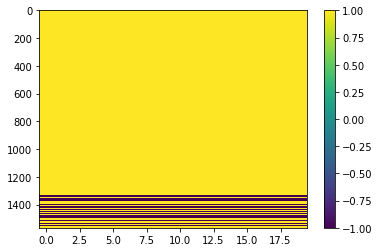

In [594]:
plt.imshow(X_mat, aspect='auto')
plt.colorbar()

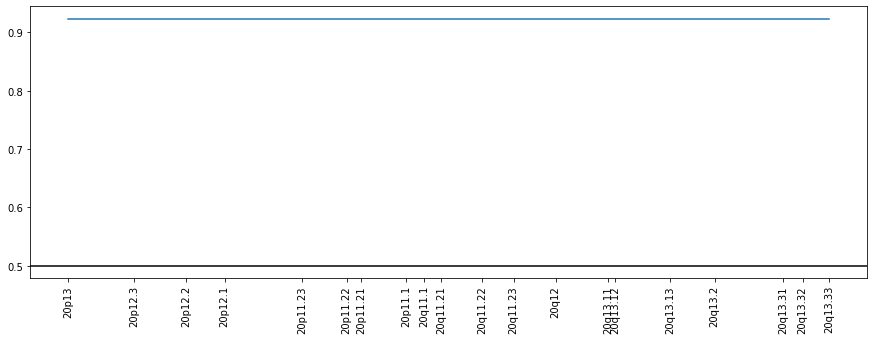

In [589]:
plt.figure(figsize=(15, 5))

plt.plot([x[2] for x in intervals], np.sum(X_mat==1, axis=0)/np.sum(X_mat!=0, axis=0))
plt.axhline(0.5, color='black')
plt.xticks([x[2] for x in intervals], ['%s%s' % (chrom, x[1]) for x in intervals], rotation=90)

plt.show()

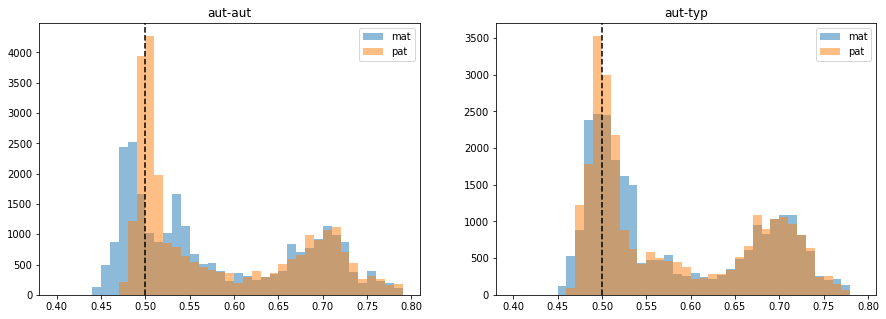

In [571]:
plt.figure(figsize=(15, 5))

bins = np.arange(0.4, 0.8, 0.01)
plt.subplot(1, 2, 1)
plt.hist(np.sum(X_mat[y, :]==1, axis=0)/np.sum(y), bins=bins, alpha=0.5, label='mat')
plt.hist(np.sum(X_pat[y, :]==1, axis=0)/np.sum(y), bins=bins, alpha=0.5, label='pat')
plt.legend()
plt.title('aut-aut')
plt.axvline(0.5, color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(np.sum(X_mat[~y, :]==1, axis=0)/np.sum(~y), bins=bins, alpha=0.5, label='mat')
plt.hist(np.sum(X_pat[~y, :]==1, axis=0)/np.sum(~y), bins=bins, alpha=0.5, label='pat')
plt.legend()
plt.title('aut-typ')
plt.axvline(0.5, color='black', linestyle='--')

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

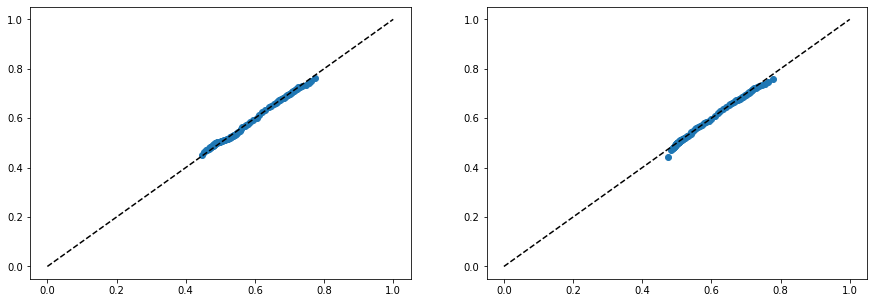

In [572]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
quantiles = np.arange(0, 1, 0.01)
plt.scatter(np.quantile(np.sum(X_mat[y, :]==1, axis=0)/np.sum(y), quantiles),
           np.quantile(np.sum(X_mat[~y, :]==1, axis=0)/np.sum(~y), quantiles))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.subplot(1, 2, 2)
quantiles = np.arange(0, 1, 0.01)
plt.scatter(np.quantile(np.sum(X_pat[y, :]==1, axis=0)/np.sum(y), quantiles),
           np.quantile(np.sum(X_pat[~y, :]==1, axis=0)/np.sum(~y), quantiles))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show

In [573]:
print(X.shape[1], 2**X.shape[0])

26315 10352213046768224942501823898758125564972691822829153230278339025972802906709060128541845496784422876659304257747961530402560498671439471495427427976767721148105940101347029203719158120999365821256286176218437922016113436796101316263127381864212945567357130891002446951817226866637935725012277154925301910771630129777340989412475020844058341394643737894544778692139363905694958460673181038773284471828946913683237937121171506218722503433123214460627233274173683244105465856


In [574]:
print(all_intervals.shape, X_mat.shape, X_pat.shape)

(25879, 2) (1568, 25879) (1568, 25879)


In [575]:
is_male_male = np.array([child_id_to_sex[x[0]] == '1' and child_id_to_sex[x[1]] == '1' for x in sibpairs])
is_male_female = np.array([child_id_to_sex[x[0]] == '1' and child_id_to_sex[x[1]] == '2' for x in sibpairs])
is_female_male = np.array([child_id_to_sex[x[0]] == '2' and child_id_to_sex[x[1]] == '1' for x in sibpairs])
is_female_female = np.array([child_id_to_sex[x[0]] == '2' and child_id_to_sex[x[1]] == '2' for x in sibpairs])

is_male = np.array([child_id_to_sex[x[0]] == '1' for x in sibpairs])
is_female = np.array([child_id_to_sex[x[0]] == '2' for x in sibpairs])


In [576]:
# cytoband majority vote

X_cytoband_mat = np.zeros((X_mat.shape[0], len(intervals)))
X_cytoband_pat = np.zeros((X_pat.shape[0], len(intervals)))
for i, interval in enumerate(intervals):
    weights = np.clip(np.minimum(all_intervals[:, 1], interval[3]) - np.maximum(all_intervals[:, 0], interval[2]), 0, None)

    # d is bases shared - bases not shared
    d = X_mat@weights
    X_cytoband_mat[:, i] = np.clip(d, -1, 1)
    X_cytoband_mat[np.abs(d)< 0.8*(interval[3] - interval[2]), i] = 0
    
    d = X_pat@weights
    X_cytoband_pat[:, i] = np.clip(d, -1, 1)
    X_cytoband_pat[np.abs(d)< 0.8*(interval[3] - interval[2]), i] = 0
    

In [577]:
from scipy.stats import binom_test

def calc_pvalues(X, y):
    pvalues = np.ones((X.shape[1], ))
    updown = np.zeros((X.shape[1], ))
    for i in range(X.shape[1]):
        c = np.array([[np.sum((X[:, i]==1) & y), np.sum((X[:, i]==1) & ~y)], [np.sum((X[:, i]==-1) & y), np.sum((X[:, i]==-1) & ~y)]])
        if np.all(c>5):
            p_autaut_given_match = np.sum(X[y, i]==1)/np.sum(X[:, i]==1)
            p_autaut_given_nomatch = np.sum(X[y, i]==-1)/np.sum(X[:, i]==-1)

            pvalues[i] = chi2_contingency(c)[1]
            #pvalues[i] = binom_test(np.sum((X[:, i]==1) & y), np.sum((X[:, i]!=0) & y))
            updown[i] = 1 if p_autaut_given_match>p_autaut_given_nomatch else -1 if p_autaut_given_match<p_autaut_given_nomatch else 0
    return pvalues, updown

pvalues_cytoband_mat = np.ones((len(intervals), 7))
updown_cytoband_mat = np.zeros((len(intervals), 7))
pvalues_cytoband_mat[:, 0], updown_cytoband_mat[:, 0] = calc_pvalues(X_cytoband_mat, y)
pvalues_cytoband_mat[:, 1], updown_cytoband_mat[:, 1] = calc_pvalues(X_cytoband_mat[is_male_male, :], y[is_male_male])
pvalues_cytoband_mat[:, 2], updown_cytoband_mat[:, 2] = calc_pvalues(X_cytoband_mat[is_male_female, :], y[is_male_female])
pvalues_cytoband_mat[:, 3], updown_cytoband_mat[:, 3] = calc_pvalues(X_cytoband_mat[is_female_male, :], y[is_female_male])
pvalues_cytoband_mat[:, 4], updown_cytoband_mat[:, 4] = calc_pvalues(X_cytoband_mat[is_female_female, :], y[is_female_female])
pvalues_cytoband_mat[:, 5], updown_cytoband_mat[:, 5] = calc_pvalues(X_cytoband_mat[is_male, :], y[is_male])
pvalues_cytoband_mat[:, 6], updown_cytoband_mat[:, 6] = calc_pvalues(X_cytoband_mat[is_female, :], y[is_female])


pvalues_cytoband_pat = np.ones((len(intervals), 7))
updown_cytoband_pat = np.zeros((len(intervals), 7))
pvalues_cytoband_pat[:, 0], updown_cytoband_pat[:, 0] = calc_pvalues(X_cytoband_pat, y)
pvalues_cytoband_pat[:, 1], updown_cytoband_pat[:, 1] = calc_pvalues(X_cytoband_pat[is_male_male, :], y[is_male_male])
pvalues_cytoband_pat[:, 2], updown_cytoband_pat[:, 2] = calc_pvalues(X_cytoband_pat[is_male_female, :], y[is_male_female])
pvalues_cytoband_pat[:, 3], updown_cytoband_pat[:, 3] = calc_pvalues(X_cytoband_pat[is_female_male, :], y[is_female_male])
pvalues_cytoband_pat[:, 4], updown_cytoband_pat[:, 4] = calc_pvalues(X_cytoband_pat[is_female_female, :], y[is_female_female])
pvalues_cytoband_pat[:, 5], updown_cytoband_pat[:, 5] = calc_pvalues(X_cytoband_pat[is_male, :], y[is_male])
pvalues_cytoband_pat[:, 6], updown_cytoband_pat[:, 6] = calc_pvalues(X_cytoband_pat[is_female, :], y[is_female])


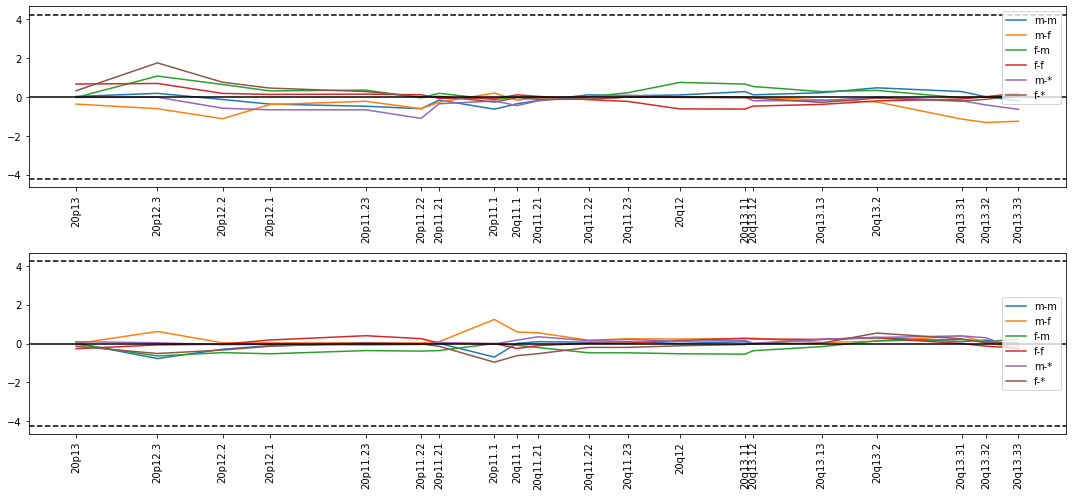

In [578]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
#plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_mat[:, 0]), updown_cytoband_mat[:, 0]), label='all')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_mat[:, 1]), updown_cytoband_mat[:, 1]), label='m-m')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_mat[:, 2]), updown_cytoband_mat[:, 2]), label='m-f')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_mat[:, 3]), updown_cytoband_mat[:, 3]), label='f-m')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_mat[:, 4]), updown_cytoband_mat[:, 4]), label='f-f')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_mat[:, 5]), updown_cytoband_mat[:, 5]), label='m-*')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_mat[:, 6]), updown_cytoband_mat[:, 6]), label='f-*')

plt.axhline(0, color='black')
plt.axhline(-np.log10(0.05/interval_count), color='black', linestyle='--')
plt.axhline(np.log10(0.05/interval_count), color='black', linestyle='--')
plt.xticks([x[2] for x in intervals], ['%s%s' % (chrom, x[1]) for x in intervals], rotation=90)
plt.legend()

plt.subplot(2, 1, 2)
#plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_pat[:, 0]), updown_cytoband_pat[:, 0]), label='all')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_pat[:, 1]), updown_cytoband_pat[:, 1]), label='m-m')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_pat[:, 2]), updown_cytoband_pat[:, 2]), label='m-f')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_pat[:, 3]), updown_cytoband_pat[:, 3]), label='f-m')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_pat[:, 4]), updown_cytoband_pat[:, 4]), label='f-f')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_pat[:, 5]), updown_cytoband_pat[:, 5]), label='m-*')
plt.plot([x[2] for x in intervals], np.multiply(-np.log10(pvalues_cytoband_pat[:, 6]), updown_cytoband_pat[:, 6]), label='f-*')

plt.axhline(0, color='black')
plt.axhline(-np.log10(0.05/interval_count), color='black', linestyle='--')
plt.axhline(np.log10(0.05/interval_count), color='black', linestyle='--')
plt.xticks([x[2] for x in intervals], ['%s%s' % (chrom, x[1]) for x in intervals], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

In [531]:
from scipy.stats import chi2_contingency

pvalues_mat = np.ones((X_mat.shape[1],))
updown_mat = np.zeros((X_mat.shape[1],))
for i in range(X_mat.shape[1]):
    c = np.array([[np.sum((X_mat[:, i]==1) & y), np.sum((X_mat[:, i]==1) & ~y)], [np.sum((X_mat[:, i]==-1) & y), np.sum((X_mat[:, i]==-1) & ~y)]])
    if np.all(c>5):
        p_autaut_given_match = np.sum(X_mat[y, i]==1)/np.sum(X_mat[:, i]==1)
        p_autaut_given_nomatch = np.sum(X_mat[y, i]==-1)/np.sum(X_mat[:, i]==-1)
    
        pvalues_mat[i] = chi2_contingency(c)[1]
        updown_mat[i] = 1 if p_autaut_given_match>p_autaut_given_nomatch else -1 if p_autaut_given_match<p_autaut_given_nomatch else 0
    
pvalues_pat = np.ones((X_pat.shape[1],))
updown_pat = np.zeros((X_pat.shape[1],))
for i in range(X_pat.shape[1]):
    c = np.array([[np.sum((X_pat[:, i]==1) & y), np.sum((X_pat[:, i]==1) & ~y)], [np.sum((X_pat[:, i]==-1) & y), np.sum((X_pat[:, i]==-1) & ~y)]])
    if np.all(c>5):
        p_autaut_given_match = np.sum(X_pat[y, i]==1)/np.sum(X_pat[:, i]==1)
        p_autaut_given_nomatch = np.sum(X_pat[y, i]==-1)/np.sum(X_pat[:, i]==-1)
        pvalues_pat[i] = chi2_contingency(c)[1]
        updown_pat[i] = 1 if p_autaut_given_match>p_autaut_given_nomatch else -1 if p_autaut_given_match<p_autaut_given_nomatch else 0
    
    
    

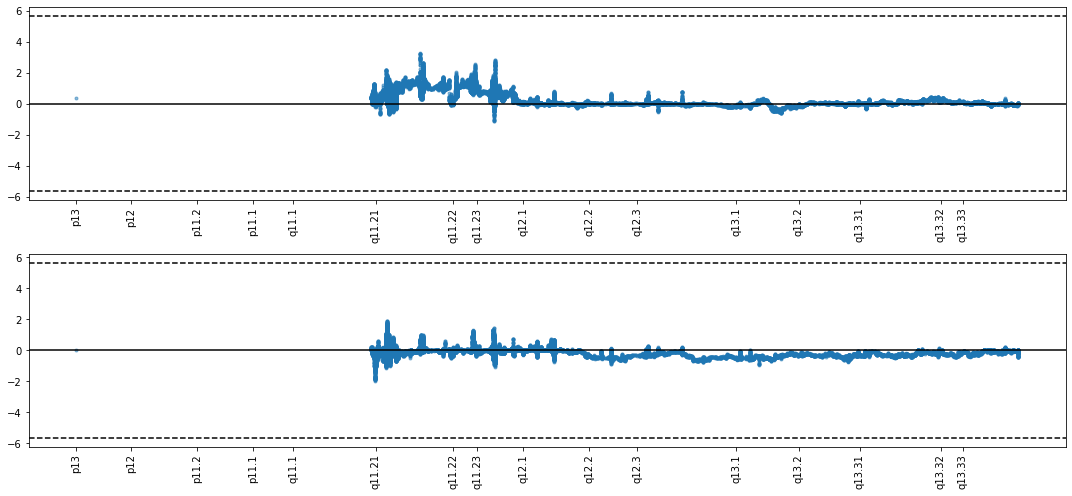

In [532]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.scatter(all_intervals[:, 0], np.multiply(-np.log10(pvalues_mat), updown_mat), alpha=0.5, marker='.')

plt.axhline(0, color='black')
plt.axhline(-np.log10(0.05/len(pvalues_mat)), color='black', linestyle='--')
plt.axhline(np.log10(0.05/len(pvalues_mat)), color='black', linestyle='--')
plt.xticks([x[2] for x in intervals], [x[1] for x in intervals], rotation=90)

plt.subplot(2, 1, 2)
plt.scatter(all_intervals[:, 0], np.multiply(-np.log10(pvalues_pat), updown_pat), alpha=0.5, marker='.')

plt.axhline(0, color='black')
plt.axhline(-np.log10(0.05/len(pvalues_pat)), color='black', linestyle='--')
plt.axhline(np.log10(0.05/len(pvalues_pat)), color='black', linestyle='--')
plt.xticks([x[2] for x in intervals], [x[1] for x in intervals], rotation=90)

plt.tight_layout()
plt.show()

In [52]:
import cvxpy as cp

# cvxpy
X = np.hstack((X_mat, X_pat, np.ones((X.shape[0], 1))))
X = np.unique(X, axis=1)
print(X.shape, y.shape)

beta = cp.Variable(X.shape[1])

lambd = 0.01
log_likelihood = cp.sum(cp.multiply(y, X @ beta) - cp.logistic(X @ beta))
objective = cp.Maximize(log_likelihood/n - lambd * cp.norm(beta, 1))
constraints = [beta[:-1]>=0]

prob = cp.Problem(objective, constraints)
result = prob.solve(solver='ECOS', max_iters=1000)
print(prob.status)
    
beta = np.asarray([v for v in beta.value])

(1568, 26315) (1568,)


KeyboardInterrupt: 

In [ ]:
indices = np.where(~np.isclose(beta, 0))[0]
print(indices.shape[0], beta[indices])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

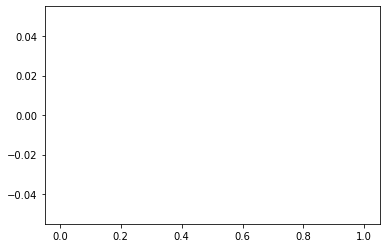

In [45]:
plt.hist(beta[indices][:-1])

In [ ]:
import statsmodels.api as sm

model = sm.Logit(y.astype(int), X.astype(int))
result = model.fit_regularized(disp=False, method='l1', alpha=100)
print(result.summary())

In [ ]:
import cvxpy as cp
